created by Ignacio Oguiza - email: oguiza@timeseriesAI.co

## 总体介绍 🤝

有时，将单变量或多变量时间序列转换为图像可能很有用，以便可以使用任何可用于图像的技术。

这些图像可以通过转换“动态”创建，其工作方式与 fastai 中任何其他转换的工作方式相同。其中一些已经转换添加到 tsai 库中。大多数转换来自优秀的“pyts”库（有关更多信息，请访问 https://pyts.readthedocs.io）。

需要注意的是，“动态”将 TS 转换为图像的速度很慢，并且可能会让训练时间过长。 如果仍然对使用 TS 作为图像感兴趣，可以测试哪些在一个小子集上效果最好，然后创建输出并将其保存为图像。然后，可以使用常规视觉数据加载器来训练视觉模型。

## 导入依赖 📚

In [ ]:
# # **************** UNCOMMENT AND RUN THIS CELL IF YOU NEED TO INSTALL/ UPGRADE TSAI ****************
# stable = True # Set to True for latest pip version or False for main branch in GitHub
# !pip install {"tsai -U" if stable else "git+https://github.com/timeseriesAI/tsai.git"} >> /dev/null

In [ ]:
!pip install tsai

In [2]:
from tsai.all import *
my_setup()

os              : Linux-6.1.58+-x86_64-with-glibc2.35
python          : 3.10.12
tsai            : 0.3.9
fastai          : 2.7.15
fastcore        : 1.5.33
torch           : 2.2.1+cu121
device          : 1 gpu (['Tesla T4'])
cpu cores       : 1
threads per cpu : 2
RAM             : 12.67 GB
GPU memory      : [15.0] GB


## 可使用的时间序列与图片转换 ⏳

tsai 库中提供了以下图像变换的时间序列：

* **TSToPlot**：创建 matplotlib 线图
* **TSToMat**：创建一个 matplotlib imshow 图
* **TSToGADF**：基于格拉米安角差场变换创建图像
* **TSToGASF**：基于格拉米安角求和场变换创建图像
* **TSToMTF**：基于马尔可夫转移场变换创建图像
* **TSToRP**：基于递归图转换创建图像

所有变换均可与**单变量或多变量时间序列**一起使用。

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Read the CSV file
df = pd.read_csv('/content/dataset_update3_bkup.csv')

# Convert the 'dataset' column to numpy arrays
df['dataset'] = df['dataset'].apply(lambda x: np.array(eval(x)))

# Convert DataFrame to numpy arrays
data = np.stack(df['dataset'].values)

# Reshape the data to a three-dimensional array
data = data.reshape(data.shape[0], 1, data.shape[1])
print(data.shape)
# Extract labels
labels = df['label'].values

(1379, 1, 51)


In [4]:
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
X, y, splits = combine_split_data([X_train, X_test], [y_train, y_test])



tfm: TSToPlot - batch shape: torch.Size([64, 3, 224, 224])


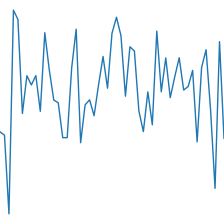



tfm: TSToMat - batch shape: torch.Size([64, 3, 224, 224])


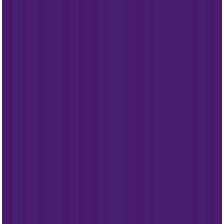



tfm: TSToGADF - batch shape: torch.Size([64, 3, 224, 224])


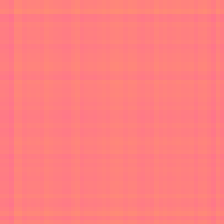



tfm: TSToGASF - batch shape: torch.Size([64, 3, 224, 224])


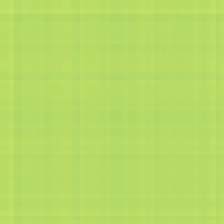



tfm: TSToMTF - batch shape: torch.Size([64, 3, 224, 224])


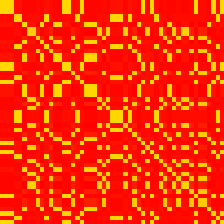



tfm: TSToRP - batch shape: torch.Size([64, 3, 224, 224])


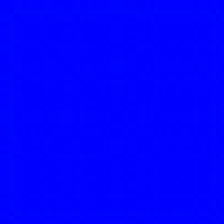

In [5]:
tfms = [None, Categorize()]
bts = [[TSNormalize(), TSToPlot()],
       [TSNormalize(), TSToMat(cmap='viridis')],
       [TSNormalize(), TSToGADF(cmap='spring')],
       [TSNormalize(), TSToGASF(cmap='summer')],
       [TSNormalize(), TSToMTF(cmap='autumn')],
       [TSNormalize(), TSToRP(cmap='winter')]]
btns = ['Plot', 'Mat', 'GADF', 'GASF', 'MTF', 'RP']
for i, (bt, btn) in enumerate(zip(bts, btns)):
    dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
    dls = TSDataLoaders.from_dsets(dsets.train,
                                   dsets.valid,
                                   bs=[64, 128],
                                   batch_tfms=bt,
                                   shuffle=False)
    xb, yb = dls.train.one_batch()
    print(f'\n\ntfm: TSTo{btn} - batch shape: {xb.shape}')
    xb[0].show()
    plt.show()

## 单变量时间序列 🦄

### TSToGADF

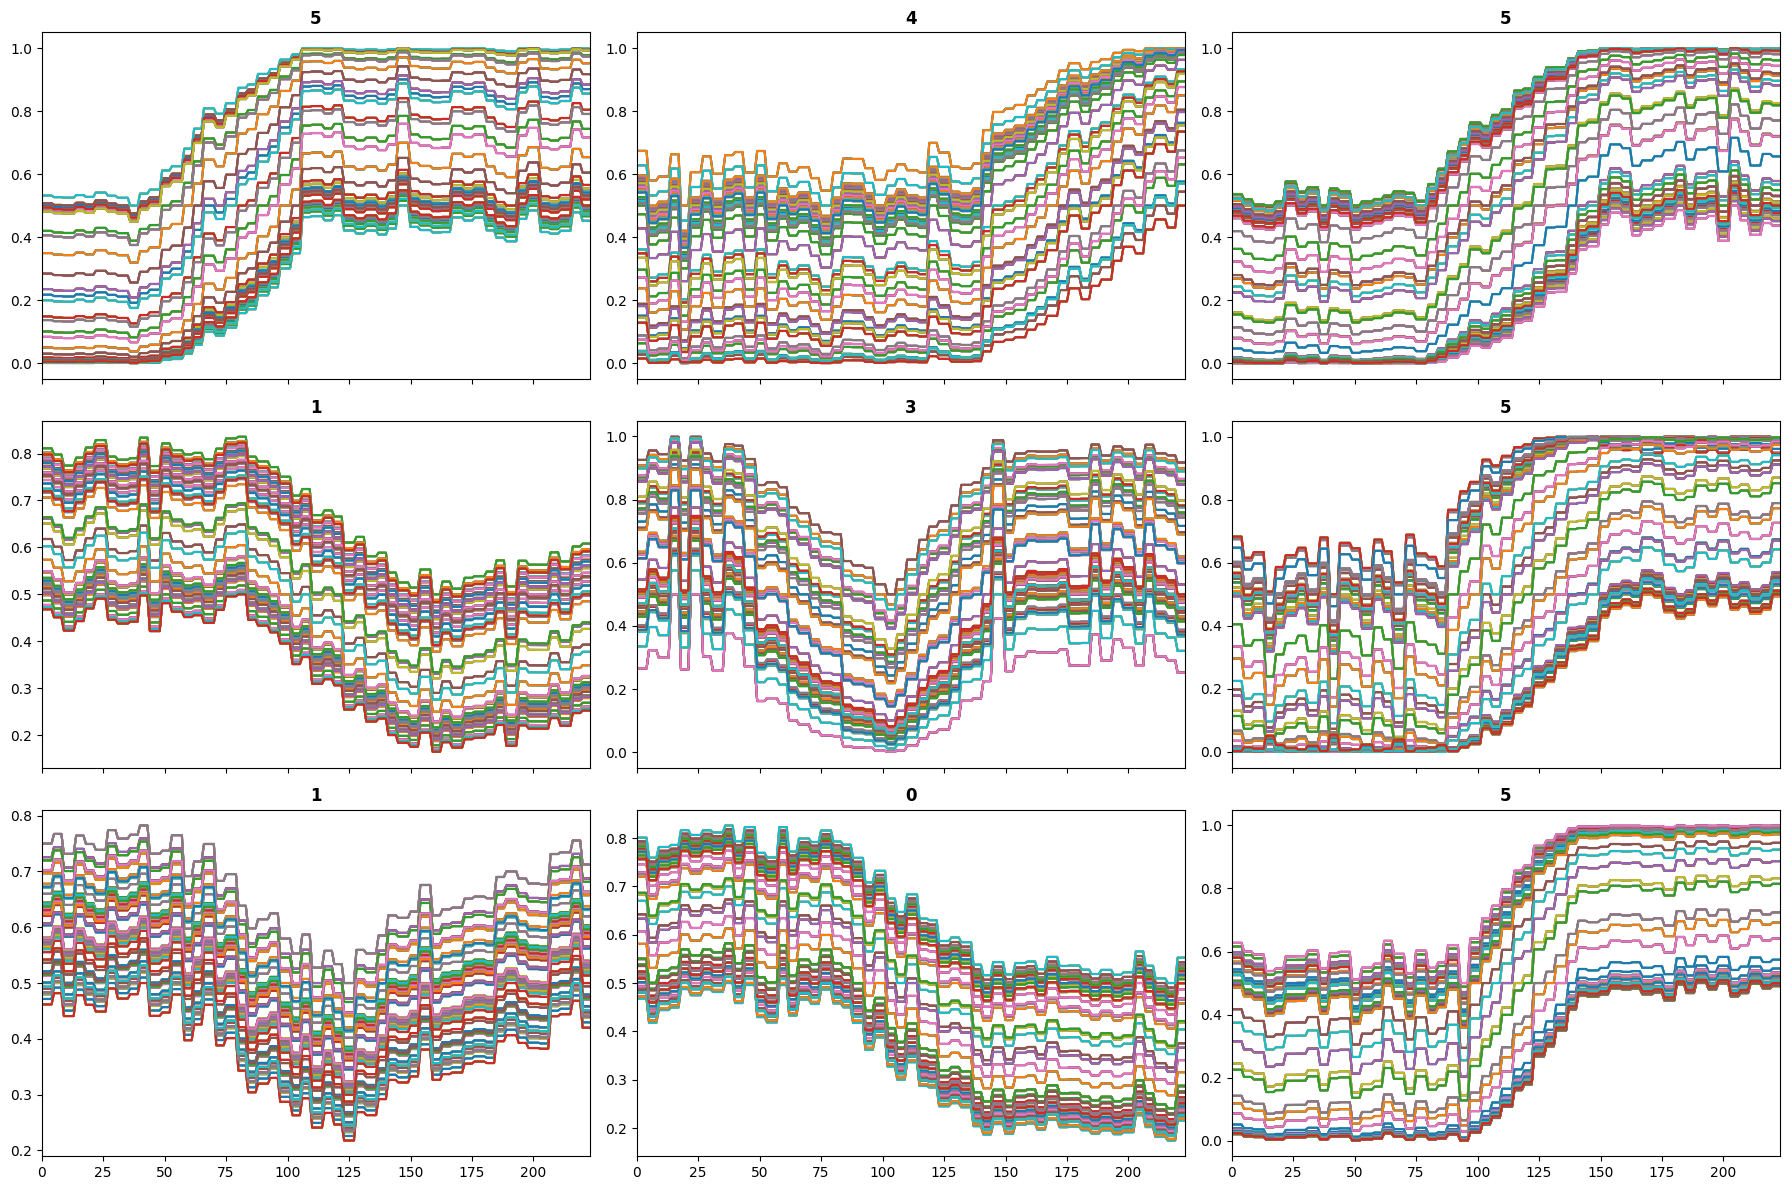

In [ ]:
tfms = [None, Categorize()]
batch_tfms = [TSNormalize(), TSToGADF()]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[16, 64], batch_tfms=batch_tfms)
dls.show_batch()

epoch,train_loss,valid_loss,accuracy,time
0,1.825284,1.758930,0.225000,00:09
1,1.620805,1.517212,0.496429,00:08
2,1.432231,1.289679,0.607143,00:08
3,1.239745,1.121868,0.675000,00:08
4,1.023007,0.875798,0.796429,00:08
5,0.810973,0.649862,0.850000,00:08
6,0.603174,0.627156,0.800000,00:08
7,0.476254,0.364428,0.925000,00:08
8,0.363505,0.370004,0.903571,00:08
9,0.305780,0.333286,0.910714,00:08



training time: 00:14:19


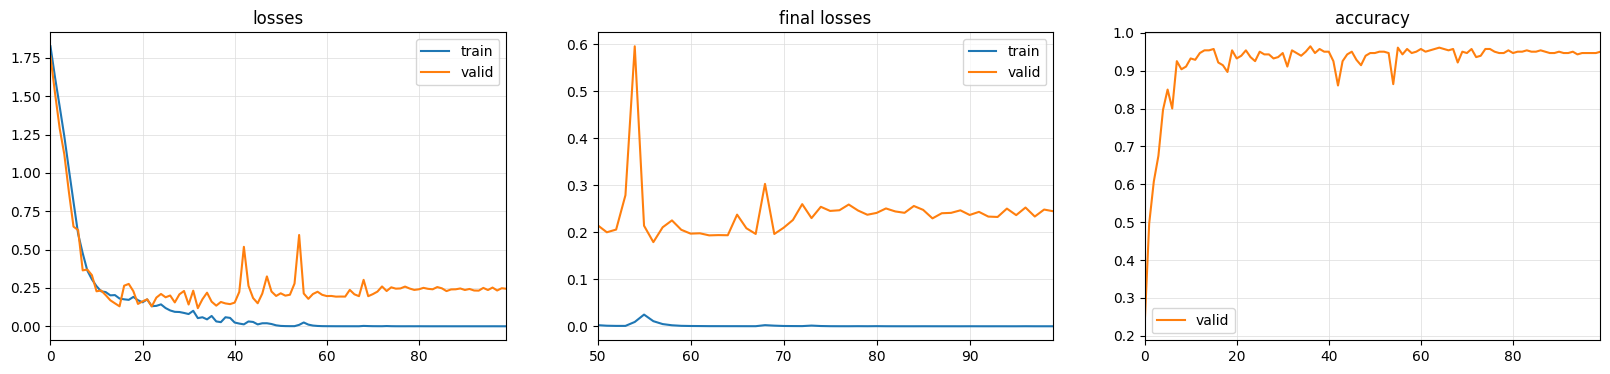

In [ ]:
model = create_model(xresnet34, dls=dls)
learn = Learner(dls, model, metrics=accuracy)
start = time.time()
learn.fit_one_cycle(100, lr_max=6e-4)
print(f"\ntraining time: {time.strftime('%H:%M:%S', time.gmtime(time.time() - start))}")
learn.plot_metrics()

跑下面这个代码，然后下载左边文件夹export和model文件夹的文件，看不见就刷新一下

In [ ]:
learn.save('ts2img_gadf_stage1')
# learn.recorder.plot_metrics()
learn.save_all(path='export', dls_fname='ts2img_gadf_100epochs_dls',
               model_fname='ts2img_gadf_100epochs_model', learner_fname='ts2img_gadf_100epochs_learner')

In [ ]:
dls = learn.dls
valid_dl = dls.valid
b = next(iter(valid_dl))
valid_probas, valid_targets, valid_preds = learn.get_preds(dl=valid_dl, with_decoded=True)
(valid_targets == valid_preds).float().mean()

tensor(0.9500)

In [ ]:
!pip install rasterio

In [ ]:
import rasterio
# Load the .tif image
with rasterio.open("/content/NDVI51years_median.tif") as src:
    image_data = src.read()
    row = image_data.shape[1]
    column = image_data.shape[2]
    # Reshape to (rows, columns, bands)
    image_data = np.transpose(image_data, (1, 2, 0))

print('transposed shape:', image_data.shape)

# Reshape the image data to (rows * columns, bands)
img_data = image_data.reshape(-1,image_data.shape[2])
print('reshaped shape:', img_data.shape)

transposed shape: (628, 620, 51)
reshaped shape: (389360, 51)


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the data
norm_data = scaler.fit_transform(img_data)

# Reshape the data back to standard shape
norm_data = to3d(norm_data)
print(norm_data.shape)

(389360, 1, 51)


In [ ]:
# Unlabelled data
test_ds = dls.dataset.add_test(norm_data)
test_dl = valid_dl.new(test_ds)
next(iter(test_dl))

(TSImage(shape:torch.Size([64, 1, 224, 224])),)

### 影像应用

In [ ]:
test_probas, test_targets, test_decoded = learn.get_preds(dl=test_dl, with_decoded=True, save_preds=None)
test_decoded

NameError: name 'learn' is not defined

In [ ]:
classified = test_decoded.reshape(row,column)
print('classified shape:',classified.shape)
print('begin saving classified image....')
# Save the classified image
with rasterio.open('/content/NDVI51years_ts2img_gadf_cls.tif', 'w', driver='GTiff',
                   height=row, width=column, count=1, dtype=rasterio.int8, crs=src.crs, transform=src.transform,
                   nodata=src.nodata, compress='lzw'
                   ) as dst:
    dst.write(classified, 1)
print('Done')